## Nanostring Cosmx dataset

In [12]:
%%time
## import the dataset
import pandas as pd
import numpy as np
import scipy
import logging
# Spatial LDA imports
from spatial_lda.featurization import neighborhood_to_cluster
from spatial_lda.featurization import make_nearest_neighbor_graph
from spatial_lda.featurization import make_merged_difference_matrices
from spatial_lda.featurization import featurize_spleens
from spatial_lda.featurization import featurize_tumors
from spatial_lda.featurization import featurize_samples
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor
import spatial_lda.model

FILE_PATH = "~/Documents/Research/github/SpaTopic_benchmarking/data/nanostring_example_lung5-1/data_spatial_lda_lung5-1.csv"
df = pd.read_csv(FILE_PATH)

df.rename(columns={'type': 'cluster', 'image': 'sample', 'sample.X': 'X', 'sample.Y': 'Y'}, inplace=True)
df['is_anchor'] = True
df_dict = {'image1':df}

CPU times: user 60 ms, sys: 31.3 ms, total: 91.3 ms
Wall time: 94.5 ms


In [13]:
%%time
## prepare feature metrix (maybe we have to adjust radius for best results, radius = 400)
cells_features = featurize_samples(df_dict, neighborhood_to_cluster, 400,'is_anchor','X','Y', 
                                   None, None, True)
cells_features

CPU times: user 31.3 s, sys: 578 ms, total: 31.9 s
Wall time: 31.8 s


,Macrophage,Plasma,CD4 T,Dendritic,Vein,B,CD8 T,Alveolar Epithelial Type 2,Goblet,Plasmacytoid Dendritic,...,Neuroendocrine,Natural Killer T,Capillary Intermediate,Lymphatic,Capillary,Fibromyocyte,Ciliated,Serous,Mesothelial,Club
"(image1, 0)",19.0,14.0,13.0,9.0,8.0,6.0,4.0,4.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(image1, 1)",9.0,4.0,4.0,8.0,8.0,5.0,9.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(image1, 2)",14.0,6.0,6.0,3.0,7.0,2.0,2.0,2.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
"(image1, 3)",12.0,5.0,5.0,1.0,7.0,4.0,2.0,1.0,0.0,2.0,...,1.0,0.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
"(image1, 4)",12.0,5.0,6.0,1.0,7.0,4.0,2.0,1.0,0.0,2.0,...,1.0,0.0,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(image1, 100144)",7.0,0.0,31.0,16.0,2.0,49.0,8.0,0.0,0.0,2.0,...,0.0,3.0,2.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0
"(image1, 100145)",9.0,2.0,32.0,11.0,0.0,26.0,10.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0
"(image1, 100146)",11.0,1.0,30.0,15.0,0.0,31.0,5.0,0.0,0.0,0.0,...,0.0,2.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0
"(image1, 100147)",8.0,4.0,5.0,8.0,0.0,3.0,5.0,1.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
## average number of neighbor cells = 100 for better result
cells_features.sum(axis = 1).mean()

97.31826578398187

In [15]:
## Prepare adjacency matrices
difference_matrices = make_merged_difference_matrices(cells_features, df_dict,
                                                             'X', 'Y')
difference_matrices

{'image1': <100148x100149 sparse matrix of type '<class 'numpy.float64'>'
 	with 200296 stored elements in Compressed Sparse Row format>}

In [16]:
%%time
## run spatial LDA
logger = logging.getLogger()
logger.setLevel(logging.INFO)
spatial_lda_model = spatial_lda.model.train(sample_features=cells_features, 
                                                difference_matrices=difference_matrices,
                                                difference_penalty=0.25,
                                                n_topics=7,
                                                n_parallel_processes=1,                                                                         
                                                verbosity=1,
                                                admm_rho=0.1,
                                                n_iters=3,
                                                primal_dual_mu=1e+5,
                                                threshold = 0.01)

INFO:root:>>> Starting iteration 0


LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:>>> Iteration 0, M-step took 162.53972911834717 seconds.
INFO:root:>>> Infering topic weights for sample image1
INFO:root:	ADMM Primal-Dual Fusion took:225.56 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.48 seconds
INFO:root:
ADDM it:0 primal res.:1073.4 dual res.:107.34. norm of v:107.34 objective: 1.881e+06 old objective: 4.7445e+06 percent change: 0.60353 rho: 0.20000 Time since start:228.08 seconds

INFO:root:	ADMM Primal-Dual Fusion took:226.50 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.49 seconds
INFO:root:
ADDM it:1 primal res.:392.3 dual res.:347.32. norm of v:107.85 objective: 1.8166e+06 old objective: 1.881e+06 percent change: 0.034246 rho: 0.20000 Time since start:457.12 seconds

INFO:root:	ADMM Primal-Dual Fusion took:227.48 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.52 seconds
INFO:root:
ADDM it:2 primal res.:219.11 dual res.:101.24. norm of v:135.43 objective: 1.783e+06 old objective: 1.8166e+06 percent change: 0.

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:>>> Iteration 1, M-step took 157.87813210487366 seconds.
INFO:root:>>> Infering topic weights for sample image1
INFO:root:	ADMM Primal-Dual Fusion took:228.00 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.52 seconds
INFO:root:
ADDM it:0 primal res.:1080.8 dual res.:108.08. norm of v:108.08 objective: 1.7815e+06 old objective: 5.0781e+06 percent change: 0.64917 rho: 0.20000 Time since start:230.56 seconds

INFO:root:	ADMM Primal-Dual Fusion took:248.04 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.87 seconds
INFO:root:
ADDM it:1 primal res.:361.03 dual res.:356.64. norm of v:99.833 objective: 1.7333e+06 old objective: 1.7815e+06 percent change: 0.027105 rho: 0.20000 Time since start:481.52 seconds

INFO:root:	ADMM Primal-Dual Fusion took:251.74 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.84 seconds
INFO:root:
ADDM it:2 primal res.:168.41 dual res.:108.23. norm of v:115.81 objective: 1.7055e+06 old objective: 1.7333e+06 percent change

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:>>> Iteration 2, M-step took 143.7365119457245 seconds.
INFO:root:>>> Infering topic weights for sample image1
INFO:root:	ADMM Primal-Dual Fusion took:241.92 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:3.63 seconds
INFO:root:
ADDM it:0 primal res.:1077.2 dual res.:107.72. norm of v:107.72 objective: 1.8043e+06 old objective: 5.6584e+06 percent change: 0.68113 rho: 0.20000 Time since start:245.60 seconds

INFO:root:	ADMM Primal-Dual Fusion took:241.70 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:3.02 seconds
INFO:root:
ADDM it:1 primal res.:354.72 dual res.:356.14. norm of v:98.059 objective: 1.7573e+06 old objective: 1.8043e+06 percent change: 0.026024 rho: 0.20000 Time since start:490.36 seconds

INFO:root:	ADMM Primal-Dual Fusion took:233.33 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:3.06 seconds
INFO:root:
ADDM it:2 primal res.:158.67 dual res.:108.67. norm of v:112.02 objective: 1.7299e+06 old objective: 1.7573e+06 percent change:

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:>>> Final M-step took 148.57471990585327 seconds.
INFO:root:>>> Training took 4711.544644117355 seconds.


CPU times: user 2h 3min 17s, sys: 5h 13min 52s, total: 7h 17min 10s
Wall time: 1h 18min 31s


In [17]:
## output result for R
import pickle
with open('/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/methods/spatial_lda/train_model/K7_spatial_lda_nanostring_v2', "wb") as f:
    pickle.dump(spatial_lda_model,f)
### save topic weights for future use
spatial_lda_model.topic_weights.to_csv('/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/methods/spatial_lda/train_model/K7_spatial_lda_nanostring_topicweights_v2.csv', index=False)

In [16]:
df_dict['image1']['sample.X'] = df_dict['image1']['X']
df_dict['image1']['sample.Y'] = df_dict['image1']['Y']
df_dict['image1']['isb'] = True
df_dict
spatial_lda_model.topic_weights

,Topic-0,Topic-1,Topic-2,Topic-3,Topic-4,Topic-5,Topic-6
"(image1, 0)",0.000792,0.000769,0.000772,0.331038,0.316268,0.251735,0.098625
"(image1, 1)",0.000912,0.000850,0.000844,0.415182,0.261952,0.318311,0.001949
"(image1, 2)",0.001032,0.183662,0.000777,0.520887,0.097979,0.194896,0.000767
"(image1, 3)",0.000860,0.214412,0.000746,0.423769,0.219394,0.140082,0.000737
"(image1, 4)",0.000847,0.201129,0.000734,0.438340,0.223253,0.134972,0.000725
...,...,...,...,...,...,...,...
"(image1, 100144)",0.471366,0.000500,0.000482,0.000493,0.423421,0.103257,0.000482
"(image1, 100145)",0.332417,0.000648,0.000625,0.001114,0.527485,0.137085,0.000625
"(image1, 100146)",0.330139,0.000613,0.000591,0.000604,0.502176,0.165287,0.000591
"(image1, 100147)",0.000917,0.120405,0.000916,0.629512,0.135584,0.111752,0.000915


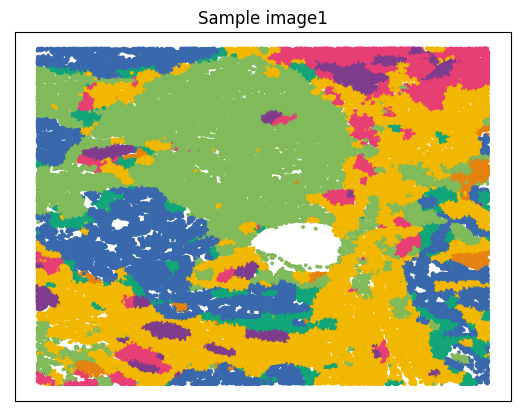

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plot_bcell_topic_multicolor(ax, "image1",spatial_lda_model.topic_weights,df_dict)
plt.show()

## Mouse Spleen

In [6]:
import pandas as pd
import numpy as np
import scipy
import logging
# Spatial LDA imports
from spatial_lda.featurization import neighborhood_to_cluster
from spatial_lda.featurization import make_nearest_neighbor_graph
from spatial_lda.featurization import make_merged_difference_matrices
from spatial_lda.featurization import featurize_spleens
from spatial_lda.featurization import featurize_tumors
from spatial_lda.featurization import featurize_samples
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_bcell_topic_multicolor
import spatial_lda.model

## read mouse spleen dataset
df_dict = pd.read_pickle("/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/data/mouse_spleen_data/spleen_df.pkl")
for df in df_dict.values():
  df['is_anchor'] = True

In [2]:
df_dict

{'BALBc-1':         Imaging phenotype cluster ID         CD45        Ly6C          TCR  \
 7                               9600  5666.397949 -155.011398  -427.121613   
 10                              9600  7034.170898 -161.461090   738.726929   
 14                              9600  1873.250610  381.250488   502.290131   
 16                              9600  3770.339111  -91.655739  -760.648010   
 20                              9600  9060.431641 -186.782639  1443.815308   
 ...                              ...          ...         ...          ...   
 254643                          9628   374.106934 -792.236816   -72.589867   
 254645                          9628  -659.748169 -881.095520  -892.728882   
 254649                          9628  1694.946777 -674.322327  -109.829102   
 254650                          9628   364.282990 -345.153564   -71.672607   
 254651                          9628  -927.240967 -224.779678 -1109.281006   
 
               Ly6G         CD19       

In [3]:
%%time
## prepare feature metrix (use the same parameters as spatial_LDA)
cells_features = featurize_samples(df_dict, neighborhood_to_cluster, 100,'is_anchor','sample.X','sample.Y', 
                                   None, None, True)
cells_features

CPU times: user 3min 32s, sys: 1.69 s, total: 3min 33s
Wall time: 3min 33s


,CD4(+) T cells,B cells,CD8(+) T cells,CD11c(+) B cells,CD106(+)CD16/32(+)CD31(-)Ly6C(-) stroma,CD4(-)CD8(-) cDC,F4/80(+) mphs,erythroblasts,CD4(-)CD8(+)cDC,ERTR7(+) stroma,...,NK cells,CD106(+)CD16/32(+)CD31(+) stroma,CD4(+)MHCII(+),B220(+) DN T cells,CD3(+) other markers (-),capsule,megakaryocytes,FDCs,CD31(hi) vascular,CD106(-)CD16/32(-)Ly6C(+)CD31(+) stroma
"(BALBc-1, 7)",16.0,6.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(BALBc-1, 10)",5.0,9.0,2.0,1.0,0.0,0.0,4.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(BALBc-1, 14)",1.0,7.0,4.0,1.0,0.0,0.0,10.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(BALBc-1, 16)",22.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(BALBc-1, 20)",6.0,4.0,0.0,1.0,3.0,0.0,8.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(MRL-9, 496273)",3.0,0.0,2.0,0.0,0.0,0.0,1.0,8.0,0.0,4.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(MRL-9, 496274)",9.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,8.0,...,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0
"(MRL-9, 496276)",3.0,0.0,2.0,0.0,0.0,0.0,1.0,7.0,0.0,5.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(MRL-9, 496282)",13.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,2.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Prepare adjacency matrices
difference_matrices = make_merged_difference_matrices(cells_features, df_dict,
                                                             'sample.X', 'sample.Y')
difference_matrices

{'BALBc-1': <81694x81695 sparse matrix of type '<class 'numpy.float64'>'
 	with 163388 stored elements in Compressed Sparse Row format>,
 'MRL-7': <79480x79490 sparse matrix of type '<class 'numpy.float64'>'
 	with 158960 stored elements in Compressed Sparse Row format>,
 'BALBc-2': <81409x81410 sparse matrix of type '<class 'numpy.float64'>'
 	with 162818 stored elements in Compressed Sparse Row format>,
 'MRL-4': <74505x74509 sparse matrix of type '<class 'numpy.float64'>'
 	with 149010 stored elements in Compressed Sparse Row format>,
 'MRL-5': <69111x69112 sparse matrix of type '<class 'numpy.float64'>'
 	with 138222 stored elements in Compressed Sparse Row format>,
 'MRL-8': <78301x78302 sparse matrix of type '<class 'numpy.float64'>'
 	with 156602 stored elements in Compressed Sparse Row format>,
 'MRL-9': <78478x78479 sparse matrix of type '<class 'numpy.float64'>'
 	with 156956 stored elements in Compressed Sparse Row format>,
 'BALBc-3': <80337x80339 sparse matrix of type '<cl

In [10]:
%%time
logger = logging.getLogger()
logger.setLevel(logging.INFO)
## run spatial LDA
spatial_lda_model = spatial_lda.model.train(sample_features=cells_features, 
                                                difference_matrices=difference_matrices,
                                                difference_penalty=0.25,
                                                n_topics=6,
                                                n_parallel_processes=1,
                                                n_iters=3,
                                                verbosity=1,
                                                admm_rho=0.1,
                                                primal_dual_mu=1e+5,threshold= 0.01)  # use treshold = 0.01 to solve the problem
### INFO:root:>>> Done inferring topic weights for sample MRL-7
#INFO:root:>>> Infering topic weights for sample MRL-8
#INFO:root:	ADMM Primal-Dual Fusion took:130.14 seconds
#INFO:root: Objective not reducing iter: 10 old: 1.402e+08 new: 1.402e+08

INFO:root:>>> Starting iteration 0


LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:>>> Iteration 0, M-step took 491.4548718929291 seconds.
INFO:root:>>> Infering topic weights for sample BALBc-1
INFO:root:	ADMM Primal-Dual Fusion took:141.54 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:1.97 seconds
INFO:root:
ADDM it:0 primal res.:847.47 dual res.:84.747. norm of v:84.747 objective: 1.2499e+06 old objective: 2.6642e+06 percent change: 0.53085 rho: 0.20000 Time since start:143.53 seconds

INFO:root:	ADMM Primal-Dual Fusion took:143.22 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:1.97 seconds
INFO:root:
ADDM it:1 primal res.:331.29 dual res.:275.11. norm of v:87.528 objective: 1.2057e+06 old objective: 1.2499e+06 percent change: 0.035368 rho: 0.20000 Time since start:288.75 seconds

INFO:root:	ADMM Primal-Dual Fusion took:145.28 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.00 seconds
INFO:root:
ADDM it:2 primal res.:188.6 dual res.:79.943. norm of v:113.44 objective: 1.1802e+06 old objective: 1.2057e+06 percent change:

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:>>> Iteration 1, M-step took 445.00820684432983 seconds.
INFO:root:>>> Infering topic weights for sample BALBc-1
INFO:root:	ADMM Primal-Dual Fusion took:143.70 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:1.83 seconds
INFO:root:
ADDM it:0 primal res.:866.43 dual res.:86.643. norm of v:86.643 objective: 1.1764e+06 old objective: 2.7812e+06 percent change: 0.57701 rho: 0.20000 Time since start:145.57 seconds

INFO:root:	ADMM Primal-Dual Fusion took:152.71 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.90 seconds
INFO:root:
ADDM it:1 primal res.:306.53 dual res.:288.09. norm of v:81.607 objective: 1.1415e+06 old objective: 1.1764e+06 percent change: 0.02973 rho: 0.20000 Time since start:301.29 seconds

INFO:root:	ADMM Primal-Dual Fusion took:193.66 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.15 seconds
INFO:root:
ADDM it:2 primal res.:152.24 dual res.:86.404. norm of v:98.326 objective: 1.1203e+06 old objective: 1.1415e+06 percent change

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:>>> Iteration 2, M-step took 408.5002145767212 seconds.
INFO:root:>>> Infering topic weights for sample BALBc-1
INFO:root:	ADMM Primal-Dual Fusion took:142.83 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:1.83 seconds
INFO:root:
ADDM it:0 primal res.:866.21 dual res.:86.621. norm of v:86.621 objective: 1.1811e+06 old objective: 3.0205e+06 percent change: 0.60897 rho: 0.20000 Time since start:144.69 seconds

INFO:root:	ADMM Primal-Dual Fusion took:150.29 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:1.94 seconds
INFO:root:
ADDM it:1 primal res.:299.73 dual res.:289.38. norm of v:79.673 objective: 1.1473e+06 old objective: 1.1811e+06 percent change: 0.028635 rho: 0.20000 Time since start:296.95 seconds

INFO:root:	ADMM Primal-Dual Fusion took:195.18 seconds
INFO:root:	ADMM Newton Regularized Dirichlet took:2.27 seconds
INFO:root:
ADDM it:2 primal res.:142.36 dual res.:87.424. norm of v:94.09 objective: 1.1265e+06 old objective: 1.1473e+06 percent change:

LDA training:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:root:>>> Final M-step took 409.7320508956909 seconds.
INFO:root:>>> Training took 25884.451997995377 seconds.


CPU times: user 12h 3s, sys: 1d 9h 13min 59s, total: 1d 21h 14min 3s
Wall time: 7h 11min 24s


In [11]:
import pickle
with open('/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/methods/spatial_lda/train_model/K6_spatial_lda_mouse_spleen', "wb") as f:
    pickle.dump(spatial_lda_model,f)
### save topic weights for future use
spatial_lda_model.topic_weights.to_csv('/Users/xiyupeng/Documents/Research/github/SpaTopic_benchmarking/methods/spatial_lda/train_model/K6_spatial_lda_mouse_spleen_topicweights.csv', index=False)